# ■ 용해탱크 AI 데이터셋 분석 진행
## 용해혼합 공정이란? :
- 분말 원재료를 액상 원재료에 녹이는 공정을 의미                                                                          
- 해당 데이터에서는 분무건조공법을 이용하여 분말 유크림, 기능성 조제 분말 등을 생산하는 것으로 원료 전처리 작업의 첫번째 단계임
- 또한 용해공정에서는 균일한 혼합물이 되는 것이 중요하기 때문에 용질과 용매의 특성, 용량, 온도, 물리적 힘등 다양한 외적 요인에 영향을 받음

## 분석 목적 :
- 용해혼합 공정 과정에서 가장 큰 영향을 주는 요인(변수)들을 식별
- 공정을 최적화 할 수 있는 분류 모델 생성

## 분석 목표 :
- EDA(Exploratory Data Analysis), VI(Variable Importance)등을 통해 공정 과정에 영향을 주는 변수들을 분석
- Machine Learning, Deep Learning(Sequence) model등을 사용해보고 성능을 비교

In [52]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier

In [54]:
os.getcwd() # 현재 위치 확인

'C:\\Users\\HOME\\전자제조데이터분석'

In [55]:
path = os.getcwd() # 현재 위치를 path 변수에 저장
os.chdir(path) # 현재 위치 변경

In [56]:
df = pd.read_csv("melting_tank.csv", encoding = 'cp949') # melting_tank 파일 불러오기

# EDA(Exploratory Data Analysis)

# 데이터 설명

|**변수 이름**|**내용**|**데이터 타입**|**독립변수/종속변수 여부**|**데이터 개수**|**결측치 여부**|
|:----:|:----:|:----:|:----:|:----:|:----:|
|STD_DT|날짜, 시간(YYYY-MM-DD HH:MM:SS)|object|인덱스로 사용|835,200|Non-Null
|NUM|인덱스|int64|×|835,200|Non-Null
|MELT_TEMP|용해 온도|int64|독립변수|835,200|Non-Null
|MOTORSPEED|용해 교반속도|int64|독립변수|835,200|Non-Null
|MELT_WEIGHT|용해탱크 내용량(중량)|int64|독립변수|835,200|Non-Null
|INSP|생산품의 수분함유량(%)|float64|독립변수|835,200|Non-Null
|TAG|불량 여부|object|종속변수|835,200|Non-Null

In [57]:
df.info() # 데이터 정보 불러오기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835200 entries, 0 to 835199
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STD_DT       835200 non-null  object 
 1   NUM          835200 non-null  int64  
 2   MELT_TEMP    835200 non-null  int64  
 3   MOTORSPEED   835200 non-null  int64  
 4   MELT_WEIGHT  835200 non-null  int64  
 5   INSP         835200 non-null  float64
 6   TAG          835200 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 44.6+ MB


In [58]:
df[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP']].describe() # 데이터프레임 요약 통계량

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
count,835200.000000,835200.000000,835200.000000,835200.000000
mean,509.200623,459.782865,582.962125,3.194853
std,128.277519,639.436413,1217.604433,0.011822
min,308.000000,0.000000,0.000000,3.170000
25%,430.000000,119.000000,186.000000,3.190000
50%,469.000000,168.000000,383.000000,3.190000
75%,502.000000,218.000000,583.000000,3.200000
max,832.000000,1804.000000,55252.000000,3.230000


## 'STD_DT'  속성을 'datetime' 타입으로 변경 후 인덱스로 지정하여 분석에 사용

In [59]:
df['STD_DT'] = df['STD_DT'].apply(lambda x: pd.to_datetime(str(x), format = '%Y-%m-%d %H:%M:%S')) # STD_DT의 형식(Object)을 datetime으로 변경

In [60]:
# 데이터프레임의 인덱스를 'STD_DT'즉 datetime(시계열 타입)으로 변경
df = df.set_index(['STD_DT'])

In [61]:
df.columns # 데이터프레임 열 출력

Index(['NUM', 'MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'TAG'], dtype='object')

In [62]:
col_name = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'TAG'] # col_name 내에 열 데이터 추출 후 저장

# 히스토그램 분석
- MELT_TEMP와 INSP는 비교적 데이터가 고르게 분포되어 있지만 MOTORSPEED, MELT_WEIGHT의 경우에는 데이터가 고르게 분포되어 있지 않고 특정 수치에 집중되어 있는 것을 확인할 수 있다.
- 종속변수에 해당하는 'TAG'의 경우 'OK'와 'NG'에서 클래스 불균형 현상을 보이고 있다. 따라서 이후 오버샘플링 과정을 통해 해당 현상을 해결해야 한다.

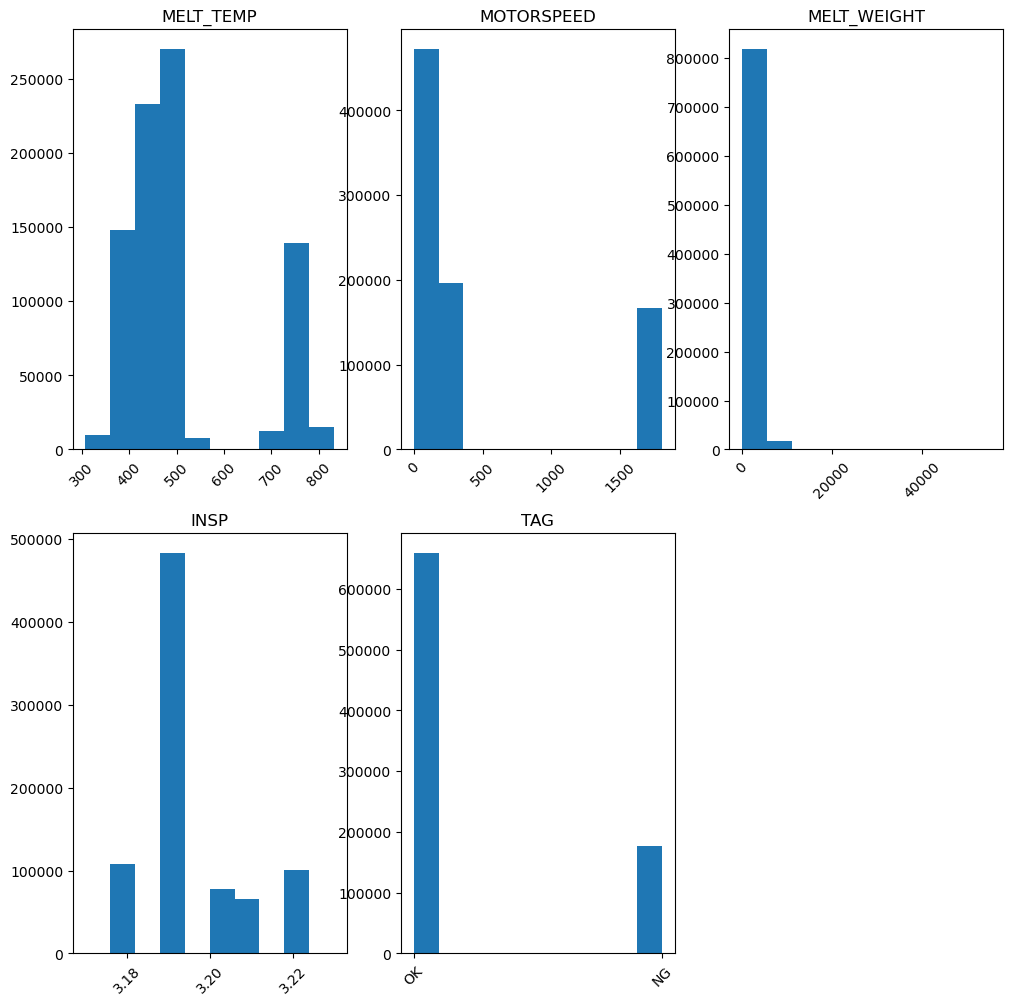

In [63]:
plt.figure(figsize = (12, 12))
for i in range(len(col_name)):
    num = 231 + i
    plt.subplot(num)
    plt.hist(df[col_name[i]])
    plt.xticks(rotation = 45)
    plt.title(col_name[i])

In [64]:
col_name = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP'] # 'TAG'를 제외한 col_name 내에 열 데이터 추출 후 저장

# 분석
- 시간대별로 'MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP'를 Plot 형태로 출력함.
- x축은 초 단위이며 **1초당 10개의 timestep**을 가지고 있음
- 해당 그래프에서는 수집주기(6초)기준으로 구간을 설정
- 'MELT_TEMP', 'MOTORSPEED', 'INSP', 'MELT_WEIGHT' 모두 특정한 패턴을 보임
- 'MELT_WEIGHT'의 경우 시간이 지나면서 지속적으로 감소하는 경향을 보임

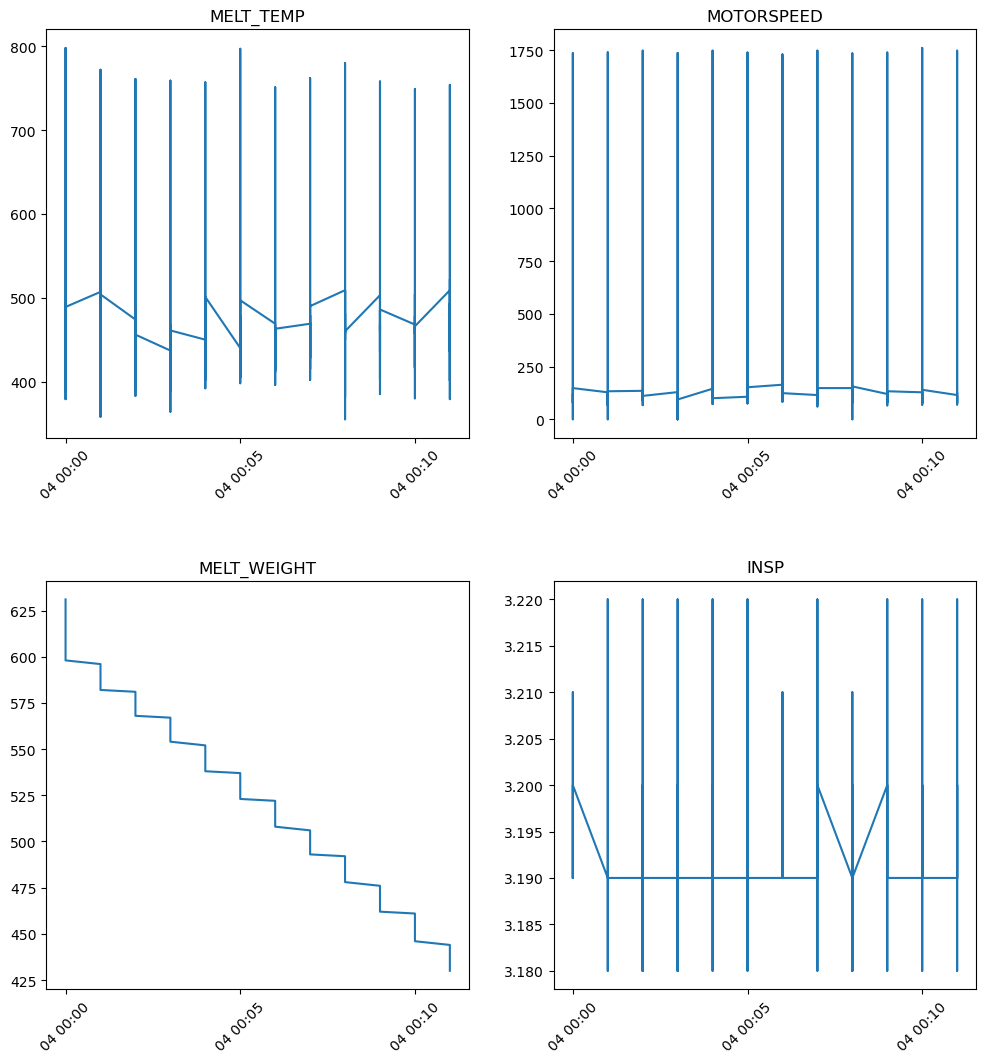

In [65]:
plt.figure(figsize = (12, 12))
for i in range(len(col_name)):
    num = 221 + i
    plt.subplot(num)
    plt.plot(df[col_name[i]][0:120])
    plt.xticks(rotation = 45)
    plt.title(col_name[i])
plt.subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.35)
plt.show()

종속변수인 'TAG'의 데이터 타입이 범주형이므로 모델링을 위해서는 숫자 형태로 인코딩을 진행해야함

In [66]:
# 범주형 변수를 숫자 형태로 인코딩

encoder =  preprocessing.LabelEncoder() 
df['TAG'] = encoder.fit_transform(df['TAG'])
df['TAG'] = df['TAG'].astype('float32')

종속변수인 'TAG'의 고유 값 개수 결과 데이터의 불균형이 발생한다. 

In [67]:
# 'TAG' 고유 값 개수

df['TAG'].value_counts()

1.0    658133
0.0    177067
Name: TAG, dtype: int64

### 독립변수와 종속변수의 상관관계 파악 'pearson'
- 상관관계를 파악한 결과 종속변수인 'TAG'와 상관계수가 가장 낮게 나오는 독립변수는 'MELT_WEIGHT'
- 가이드북에서는 상관계수가 낮은 독립변수를 미리 제거하고 모델링을 진행하지만 본 프로젝트에서는 제거하지 않고 실제 모델에 어떤 영향을 미치는지 알아보기 위해 모두 포함하여 모델링을 진행함

In [68]:
# 데이터프레임 상관계수 'pearson'

corr = df.corr(method = 'pearson')
corr

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
NUM,1.000000,0.000188,-0.000050,0.080079,-0.000524,0.086698
MELT_TEMP,0.000188,1.000000,0.944929,-0.000336,0.916295,0.310586
MOTORSPEED,-0.000050,0.944929,1.000000,0.000123,0.887813,0.264693
MELT_WEIGHT,0.080079,-0.000336,0.000123,1.000000,-0.000005,-0.012084
INSP,-0.000524,0.916295,0.887813,-0.000005,1.000000,0.272580
TAG,0.086698,0.310586,0.264693,-0.012084,0.272580,1.000000


# 사용할 데이터 프레임을 df1에 저장

In [69]:
df1 = df[['MELT_TEMP', 'MOTORSPEED', 'TAG']]

# 데이터 셋 분리 : 70%

In [70]:
split_date = int(df1.shape[0] * 0.7)

train = df1[:split_date]
test = df1[split_date:]

# train set과 test set 형태 출력

In [71]:
print(train.shape); print(test.shape)

(584640, 3)
(250560, 3)


# 데이터 정규화 진행 : MinMaxScaler

In [72]:
scaler = preprocessing.MinMaxScaler()

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

# 독립변수와 종속변수를 분리

In [73]:
X_train_values = train_sc[:, :-1] # 독립변수 분리
y_train_values = train_sc[:,-1] # 종속변수 분리

# SMOTE를 적용 후 데이터 불균형 문제 해결

In [74]:
smote = SMOTE(random_state = 0)

X_train_over, y_train_over = smote.fit_resample(X_train_values, y_train_values)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train_values.shape, y_train_values.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (584640, 2) (584640,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :  (821032, 2) (821032,)
SMOTE 적용 후 레이블 값 분포: 
 1.0    410516
0.0    410516
dtype: int64


# make_dataset 함수 생성

In [75]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

# 훈련 데이터 셋 분리

In [76]:
X_train_over = pd.DataFrame(X_train_over, columns = ['MELT_TEMP', 'MOTORSPEED'])
y_train_over = pd.DataFrame(y_train_over, columns = ['TAG'])

In [77]:
train_feature, train_label = make_dataset(X_train_over, y_train_over, 10)

In [78]:
test_sc = pd.DataFrame(test_sc, columns = ['MELT_TEMP', 'MOTOR_SPEED', 'TAG'])

In [79]:
feature_cols = ['MELT_TEMP', 'MOTOR_SPEED']
label_cols = ['TAG']

In [80]:
test_feature = test_sc[feature_cols]
test_label = test_sc[label_cols]

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 10)
test_feature.shape, test_label.shape

((250550, 10, 2), (250550, 1))

In [81]:
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size = 0.3)

x_train.shape, x_valid.shape

((574715, 10, 2), (246307, 10, 2))

In [82]:
# 모델 구축
model = Sequential()
model.add(LSTM(50,
               input_shape = (train_feature.shape[1], train_feature.shape[2]),
               activation = 'tanh',
               return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

In [83]:
model_path = path

In [84]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
early_stop = EarlyStopping(monitor = 'val_loss', patience=5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor = 'val_loss', verbose = 0,
                             save_best_only = True, mode = 'auto')

In [85]:
history = model.fit(x_train, y_train,
                    epochs = 100,
                    batch_size = 50,
                    validation_data = (x_valid, y_valid),
                    callbacks = [early_stop, checkpoint])

Epoch 1/100
11495/11495 [==============================] - 51s 4ms/step - loss: 0.3622 - accuracy: 0.7960 - val_loss: 0.3464 - val_accuracy: 0.8037
Epoch 2/100
11495/11495 [==============================] - 51s 4ms/step - loss: 0.3470 - accuracy: 0.8046 - val_loss: 0.3459 - val_accuracy: 0.8040
Epoch 3/100
11495/11495 [==============================] - 50s 4ms/step - loss: 0.3466 - accuracy: 0.8043 - val_loss: 0.3456 - val_accuracy: 0.8053
Epoch 4/100
11495/11495 [==============================] - 51s 4ms/step - loss: 0.3464 - accuracy: 0.8045 - val_loss: 0.3457 - val_accuracy: 0.8029
Epoch 5/100
11495/11495 [==============================] - 50s 4ms/step - loss: 0.3463 - accuracy: 0.8047 - val_loss: 0.3459 - val_accuracy: 0.8039
Epoch 6/100
11495/11495 [==============================] - 50s 4ms/step - loss: 0.3462 - accuracy: 0.8053 - val_loss: 0.3458 - val_accuracy: 0.8053
Epoch 7/100
11495/11495 [==============================] - 50s 4ms/step - loss: 0.3462 - accuracy: 0.8050 - val_

In [86]:
model.load_weights(filename)

pred = model.predict(test_feature)

7830/7830 [==============================] - 13s 2ms/step


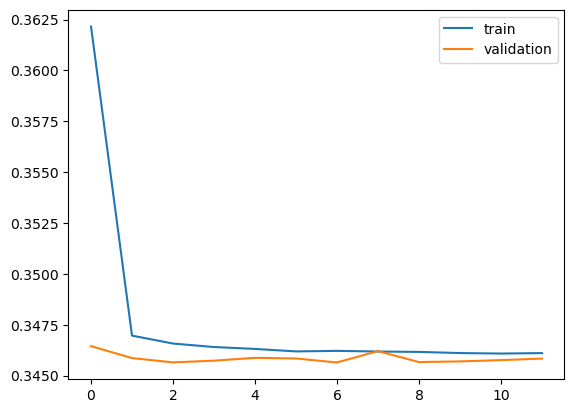

In [87]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()
plt.show()

In [112]:
pred_df = pd.DataFrame(pred, columns = ['TAG'])

In [113]:
pred_df['TAG'] = pred_df['TAG'].apply(lambda x: 1 if x >= 0.5 else 0)

In [114]:
pred_df['TAG'].value_counts()

1    200440
0     50110
Name: TAG, dtype: int64

In [115]:
classify = confusion_matrix(test_label, pred_df)
print(classify)

[[  2155    785]
 [ 47955 199655]]


In [116]:
p = precision_score(test_label, pred_df)
print("precision: %0.4f" %p)

r = recall_score(test_label, pred_df)
print("recall: %0.4f" %r)

f1 = f1_score(test_label, pred_df)
print("f1-score: %0.4f" %f1)

acc = accuracy_score(test_label, pred_df)
print("accuracy: %0.4f" %acc)

precision: 0.9961
recall: 0.8063
f1-score: 0.8912
accuracy: 0.8055
